In [1]:
import numpy as np
from numpy.random import rand
import csv
import h5py
import signal
import fast5
import fastq
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
"""
checks to see if gpu is working
"""
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c)) 

[[22. 28.]
 [49. 64.]]


In [3]:
"""
this function divides the length of whatever 
size the list is by 4 for a 4mer
"""
def BaseFunction(x,y): 
    return((len(x)//y),y)

In [4]:
"""
this function divides the length of whatever 
size the list is by 40 for a 40mer
"""
def SigFunction(x,y): 
    return((y),((x//y)))

In [5]:
"""
this function provides information about the array    
"""
def array_inspect(x):
    print ("Shape is",(x.shape))
    print(("Length is",len(x)))
    print(("Dimension is",x.ndim))
    print(("Total Size is",x.size))
    print(("Type is",x.dtype))
    print(("Type Name is",x.dtype.name))

In [6]:
"""
this function normalizes the raw signal resistances
from each read by dividing by the mean(or std?)
"""
def normalize(x,y):
    z=np.divide(x,y)
    #np.savetxt("NormalizedSigArray_{}.csv".format(),(z), delimiter=",")
    return z

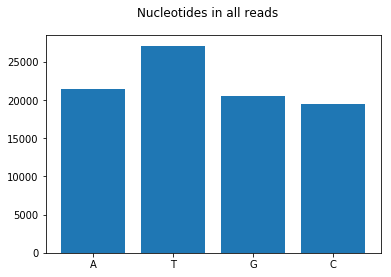

In [43]:
"""
This cell does the following
    1)Imports the bases
    2)trims off the new lines and digits
    3)converts them to a list
    4)converts them to a code of 0123 instead of ATCG
"""
f = open("fasta/sampled_read.fasta","r") #opens the file with the reads
a = f.read()
base = [re.sub(">|\n|\d", "",str) for str in a]
baseA0 = [re.sub("A","0",str) for str in base]
baseT1 = [re.sub("T","1",str) for str in baseA0]
baseG2 = [re.sub("C","2",str) for str in baseT1]
base_coded = [re.sub("G","3",str) for str in baseG2] 
A0=(a.count("A")) 
T1=(a.count("T"))
G2=(a.count("G"))
C3=(a.count("C"))
names = ['A', 'T', 'G', 'C']
values = [(A0), (T1), (G2), (C3)]

plt.subplot()
plt.bar(names, values)
plt.suptitle('Nucleotides in all reads')
plt.show()

In [9]:
"""
The purpose of this code is the following
1)Convert the coded reads to integer form 
2)Create an array inside the array with each read as a row
3)Create a 2D matric with the counts of all the possible scenarios 
presented in each row and the reads in each column
4)Create a 1D array with the readlengths
"""
kmer=[]
kmercount=[]
reads=[]
readslength=[]
res=(len(base_coded))   
for x in range(res):
    l=list(int (i) for i in base_coded[x])
    for y in range(1):
        i=(l.count(y), l.count(y+1), l.count(y+2), l.count(y+3))
        kmercount.append(i)
        n=np.transpose(kmercount) # creates a 2D matrix with the bases counts as rows(ATGC) and the reads by columns
        kmer = n.view() #Create a view of the array with the same data
    d=np.asarray(l)
    d.resize((BaseFunction(d,4))) #Enter the list and the desired kmer for the function
    v=(str(d))
    reads.append(d) # store the reads in an array called reads
    c=len(d)
    readslength.append(c) #store the amt of kmer reads in readlength=

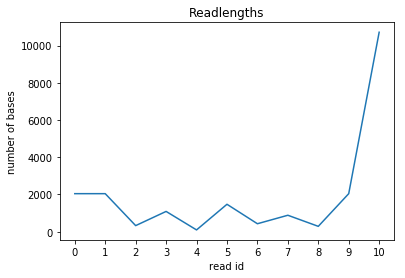

In [10]:
"""
The purpose of this code is the following
1) visualize the readlengths
"""
plt.ioff()
for i in range(1):
    plt.title("Readlengths")
    plt.ylabel('number of bases')
    plt.xlabel('read id')
    plt.plot(kmer[i])
    plt.xticks(np.arange(0, 11))
    plt.show()

In [44]:
"""
The cell does the following:
    1) Import the signal level data
    2) Normalize it to the mean fof the signal
    3) Appends the signal data from each read into a row of an array given the read count
"""
means = [] 
std = []
sig = []
for x in range(11):
    a=np.loadtxt("signal/signal_{}.txt".format(x)) # load the signal
    m=a.mean() #obtain the average signal from the read
    b=normalize(m,a) # divide each resistance by the average to normalize 
    c=b.size #obtains the number of resistance signals per read
    #print("resist",c)
    d=readslength[x] #obtains the kmers count per read
    #print("kmer",d)
    e=SigFunction(c,d) #figures out the average amount of resistances per kmer
    #print("Signal",x,"2D array size={}".format(e))
    b.resize(e) # Insert the (#bases,#sig) changes the signal level n signals wide
    sig.append(b)

In [46]:
"""
The goal for this cell is to convert the reads to string
index the unique outputs for the 4mers
and create a new list of the indexed [1:256 or whatever]
reads for the model
"""
arr2=[] # In this code I converted the reads to a concated string of a 4mer
converted=[]
converted2=[]
for i, v in enumerate(reads[10]): #Read 0 is the training data
    temp = ''
    for w in v:
        temp = temp + str(w)
    arr2.append(temp)
a=np.unique(arr2) # makes an array of every unique combo in the read for downstream indexing
for x in arr2:
    #print(x)
    b=enumerate(a)
    c=[(i) for i, j in b if a[i]==(x)]
    converted.append(c)
for i, v in enumerate(converted): #Read 0 is the training data
    temp = ''
    #print(v)
    for w in v:
        #print(w)
        temp = temp + str(w)
    converted2.append(temp)
y_train=np.int16(converted2)

In [128]:
"""
I just copied the same code for the testing set read(1)
"""
arr2=[] # In this code I converted the reads to a concated string of a 4mer
converted=[]
converted2=[]
for x in range(1):
    for i, v in enumerate(reads[x]): #Read 0 is the training data
        temp = ''
        for w in v:
            temp = temp + str(w)
        arr2.append(temp)
    a=np.unique(arr2)# makes an array of every unique combo in the read for downstream indexing
    for x in arr2:
        #print(x)
        b=enumerate(a)
        c=[(i) for i, j in b if a[i]==(x)]
        converted.append(c)
    for i, v in enumerate(converted): #Read 0 is the training data
        temp = ''
        for w in v:
            temp = temp + str(w)
        converted2.append(temp)
    n=np.unique(converted2)
    print((n.size))
y_test=np.int16(converted2)

243


In [129]:
x_train = sig[10]
x_test = sig[1]

In [130]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu)) # uses 128 neurons and is a feed forward rectilinear relu
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu)) # do the same thig for hidden layer 2
model.add(tf.keras.layers.Dense(256, activation=tf.nn.softmax)) # output layer with number of classifications (256) use softmax for output distribution


In [131]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
#model.fit(x_train, y_train, epochs=30)
history = model.fit(x_train,y_train,
                    epochs=400)#batch_size=11063,verbose=1)

Epoch 1/400
11063/11063 [==============================] - 1s 66us/step - loss: 5.3767 - acc: 0.0128
Epoch 2/400
11063/11063 [==============================] - 1s 64us/step - loss: 5.3548 - acc: 0.0134
Epoch 3/400
11063/11063 [==============================] - 1s 65us/step - loss: 5.3495 - acc: 0.0138
Epoch 4/400
11063/11063 [==============================] - 1s 63us/step - loss: 5.3454 - acc: 0.0145
Epoch 5/400
11063/11063 [==============================] - 1s 65us/step - loss: 5.3437 - acc: 0.0144
Epoch 6/400
11063/11063 [==============================] - 1s 66us/step - loss: 5.3396 - acc: 0.0148
Epoch 7/400
11063/11063 [==============================] - 1s 69us/step - loss: 5.3378 - acc: 0.0140
Epoch 8/400
11063/11063 [==============================] - 1s 66us/step - loss: 5.3344 - acc: 0.0147
Epoch 9/400
11063/11063 [==============================] - 1s 67us/step - loss: 5.3322 - acc: 0.0151
Epoch 10/400
11063/11063 [==============================] - 1s 67us/step - loss: 5.3287 - a

11063/11063 [==============================] - 1s 70us/step - loss: 4.9962 - acc: 0.0276 ETA: 0s - loss: 4.9469
Epoch 82/400
11063/11063 [==============================] - 1s 72us/step - loss: 4.9909 - acc: 0.0286
Epoch 83/400
11063/11063 [==============================] - 1s 66us/step - loss: 4.9871 - acc: 0.0287
Epoch 84/400
11063/11063 [==============================] - 1s 66us/step - loss: 4.9804 - acc: 0.0288
Epoch 85/400
11063/11063 [==============================] - 1s 68us/step - loss: 4.9749 - acc: 0.0285
Epoch 86/400
11063/11063 [==============================] - 1s 72us/step - loss: 4.9704 - acc: 0.0297
Epoch 87/400
11063/11063 [==============================] - 1s 71us/step - loss: 4.9672 - acc: 0.0283
Epoch 88/400
11063/11063 [==============================] - 1s 67us/step - loss: 4.9605 - acc: 0.0311
Epoch 89/400
11063/11063 [==============================] - 1s 76us/step - loss: 4.9589 - acc: 0.0313
Epoch 90/400
11063/11063 [==============================] - 1s 68us/step

11063/11063 [==============================] - 1s 66us/step - loss: 4.6661 - acc: 0.0553
Epoch 161/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.6595 - acc: 0.0575
Epoch 162/400
11063/11063 [==============================] - 1s 68us/step - loss: 4.6566 - acc: 0.0594
Epoch 163/400
11063/11063 [==============================] - 1s 65us/step - loss: 4.6512 - acc: 0.0599
Epoch 164/400
11063/11063 [==============================] - 1s 69us/step - loss: 4.6493 - acc: 0.0581
Epoch 165/400
11063/11063 [==============================] - 1s 67us/step - loss: 4.6496 - acc: 0.0596
Epoch 166/400
11063/11063 [==============================] - 1s 71us/step - loss: 4.6426 - acc: 0.0625
Epoch 167/400
11063/11063 [==============================] - 1s 82us/step - loss: 4.6372 - acc: 0.0614
Epoch 168/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.6335 - acc: 0.0620
Epoch 169/400
11063/11063 [==============================] - 1s 75us/step - loss: 4.629

11063/11063 [==============================] - 1s 85us/step - loss: 4.4506 - acc: 0.0817
Epoch 240/400
11063/11063 [==============================] - 1s 82us/step - loss: 4.4421 - acc: 0.0824
Epoch 241/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.4447 - acc: 0.0850
Epoch 242/400
11063/11063 [==============================] - 1s 66us/step - loss: 4.4457 - acc: 0.0840
Epoch 243/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.4415 - acc: 0.0821
Epoch 244/400
11063/11063 [==============================] - 1s 78us/step - loss: 4.4421 - acc: 0.0829
Epoch 245/400
11063/11063 [==============================] - 1s 90us/step - loss: 4.4377 - acc: 0.0838
Epoch 246/400
11063/11063 [==============================] - 1s 81us/step - loss: 4.4354 - acc: 0.0821
Epoch 247/400
11063/11063 [==============================] - 1s 75us/step - loss: 4.4338 - acc: 0.0849
Epoch 248/400
11063/11063 [==============================] - 1s 82us/step - loss: 4.432

11063/11063 [==============================] - 1s 76us/step - loss: 4.3157 - acc: 0.0973
Epoch 319/400
11063/11063 [==============================] - 1s 63us/step - loss: 4.3240 - acc: 0.0956
Epoch 320/400
11063/11063 [==============================] - 1s 80us/step - loss: 4.3168 - acc: 0.0956
Epoch 321/400
11063/11063 [==============================] - 1s 67us/step - loss: 4.3182 - acc: 0.0974
Epoch 322/400
11063/11063 [==============================] - 1s 66us/step - loss: 4.3136 - acc: 0.0996
Epoch 323/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.3094 - acc: 0.0995
Epoch 324/400
11063/11063 [==============================] - 1s 68us/step - loss: 4.3148 - acc: 0.0973
Epoch 325/400
11063/11063 [==============================] - 1s 71us/step - loss: 4.3092 - acc: 0.0992
Epoch 326/400
11063/11063 [==============================] - 1s 79us/step - loss: 4.3092 - acc: 0.0985
Epoch 327/400
11063/11063 [==============================] - 1s 71us/step - loss: 4.302

11063/11063 [==============================] - 1s 71us/step - loss: 4.2338 - acc: 0.1060
Epoch 398/400
11063/11063 [==============================] - 1s 71us/step - loss: 4.2289 - acc: 0.1083
Epoch 399/400
11063/11063 [==============================] - 1s 70us/step - loss: 4.2293 - acc: 0.1104
Epoch 400/400
11063/11063 [==============================] - 1s 68us/step - loss: 4.2382 - acc: 0.1078


In [132]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss)
print(val_acc)


2078/2078 [==============================] - 0s 96us/step
5.553015421168866
0.007218479307025986


In [52]:
#model.save('tensorflow_basecaller.model')
#new_model = tf.keras.models.load_model('tensorflow_basecaller.model')

In [133]:
predictions = model.predict(x_test)

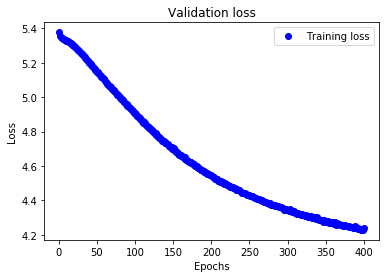

In [134]:
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

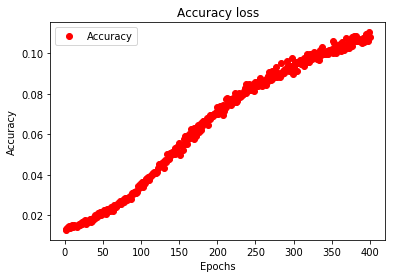

In [135]:
plt.plot(epochs, acc, 'ro', label='Accuracy')
plt.title('Accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [136]:
print(np.argpartition(kth=255,a=predictions[0])) #why is 85 the max number

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 255 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24